In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from scipy.optimize import lsq_linear

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta

pd.set_option('display.max_rows', 500)

In [2]:
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

In [3]:
def AR(data_series, p):
    data = pd.DataFrame(data_series.values, columns=["original"])
    if p == 0:
        data["predicted"] = data_series.mean()
        return data

    # set up the lags
    for lag in range(1, p+1):
        data[f"lag_{lag}"] = data["original"].shift(lag)

    # first column in data is the y
    y = data.iloc[p:, 0]
    X = data.iloc[p:, 1:]

    model = LinearRegression().fit(X, y)
    intercept = model.intercept_
    coefs = model.coef_
    print(intercept)
    print(coefs)
    predicted = X.dot(coefs.T) + intercept
    data["predicted"] = predicted
    #data[["original", "predicted"]].plot()
    #plt.show()
    return data
    

In [4]:
def MA(data_series, q):
    data = pd.DataFrame(data_series.values, columns=["error"])
    if q == 0:
        data["predicted"] = data_series.mean()
        return data

    # set up the lags
    for lag in range(1, q+1):
        data[f"lag_{lag}"] = data["error"].shift(lag)

    # first column in data is the y
    y = data.iloc[q:, 0]
    X = data.iloc[q:, 1:]

    model = LinearRegression().fit(X, y)
    intercept = model.intercept_
    coefs = model.coef_

    print(intercept)
    print(coefs)

    predicted = X.dot(coefs.T) + intercept
    data["predicted"] = predicted

    return data

In [5]:
'''
def myARIMA(data_series, p, d, q, plot=True):
    ar_coefs = None
    ma_coefs = None
    split = int(0.8 * len(data_series))

    # data = pd.DataFrame(data_series.values, columns=["original"])
    data_series = data_series.asfreq('MS')

    train = data_series.iloc[:split]
    test_X = data_series.iloc[split:]
    
    data = pd.DataFrame(train.values, index=train.index, columns=["original"])
    data["Diff"] = data["original"]
    for _ in range(d):
        data["Diff"] = data["Diff"].diff()

    mu = data["Diff"].mean()
    data["Diff"].fillna(mu)
    
    # ar = pd.DataFrame((data["Diff"]).values, columns=["original"])
    ar = pd.DataFrame((data["Diff"]).values, index=data.index, columns=["original"])
    if p == 0:
        ar["predicted"] = mu
    else:
        # set up the lags
        # print(ar["original"].shift(1, freq="infer"))
        shifted = ar["original"].shift(1, freq="infer")
        for lag in range(1, p+1):
            # ar[f"lag_{lag}"] = ar["original"].shift(lag, freq="infer")
            test = shifted
            test_df = pd.DataFrame(test.values, index=test.index, columns=[f"lag_{lag}"])
            ar = pd.concat([ar, test_df], axis=1)
            shifted = shifted.shift(1)
        ar = ar.fillna(0)

        # get X and y
        X = ar.loc[data.index].iloc[:, 1:]
        y = ar.loc[data.index].iloc[:, 0]

        ar_coefs = lsq_linear(X, y).x
        ar["predicted"] = X.dot(ar_coefs.T)
    
    data["AR_predicted"] = ar["predicted"]

    # ma = pd.DataFrame((ar["original"] - ar["predicted"]).values, columns=["error"])
    # print(ar)
    ma = pd.DataFrame((ar["original"].loc[data.index] - ar["predicted"].loc[data.index]).values, index=train.index, columns=["error"])

    if q == 0:
        # ma["predicted"] = ma["error"].mean()
        ma["predicted"] = 0
    else:
        # set up the lags
        shifted = ma["error"].shift(1, freq="infer")
        for lag in range(1, q+1):
            # ma[f"lag_{lag}"] = ma["error"].shift(lag, freq="infer")
            test = shifted
            test_df = pd.DataFrame(test.values, index=test.index, columns=[f"lag_{lag}"])
            ma = pd.concat([ma, test_df], axis=1)
            shifted = shifted.shift(1)

        ma = ma.fillna(0)
        # get X and y
        X = ma.loc[data.index].iloc[:, 1:]
        y = ma.loc[data.index].iloc[:, 0]

        ma_coefs = lsq_linear(X, y).x
        ma["predicted"] = X.dot(ma_coefs.T)
    # print(ma)
    data["MA_predicted"] = ma["predicted"]
    # Can't handle d > 1 at the moment lol
    if d == 1:
        data["predicted"] = data["original"].shift() + mu + data["AR_predicted"] + data["MA_predicted"]
    else:
        data["predicted"] = mu + data["AR_predicted"] + data["MA_predicted"]
    data = data.fillna(0)

    # rmse_df = pd.DataFrame(data[["original", "predicted"]])
    # rmse =  mean_squared_error(rmse_df["original"], rmse_df["predicted"])
    rmse = 0
    
    # for i in range(len(test_X)):
    for i in range(len(test_X)):
        next_time = data.index[-1] + data.index.freq
        last_ar = ar.iloc[-1, 1:-1]
        last_ma = ma.iloc[-1, 1:-1]
        ar_pred = last_ar.dot(ar_coefs.T) if p > 0 else mu
        ma_pred = last_ma.dot(ma_coefs.T) if q > 0 else 0
        # print(ar_pred, ma_pred, mu)
        last_obs = data["original"][-1]

        pred = last_obs + mu + ar_pred + ma_pred
        new_obs = test_X.iloc[0].values[0]
        ar.loc[next_time]["predicted"] = ar_pred
        ma.loc[next_time]["predicted"] = ma_pred

        new_ar = pd.DataFrame(ar["original"], index=ar.index)
        if p == 0:
            new_ar["predicted"] = mu
        else:
            # set up the lags
            # print(new_ar["original"].shift(1, freq="infer"))
            shifted = ar["original"].shift(1, freq="infer")
            for lag in range(1, p+1):
                # new_ar[f"lag_{lag}"] = new_ar["original"].shift(lag, freq="infer")
                test = shifted
                test_df = pd.DataFrame(test.values, index=test.index, columns=[f"lag_{lag}"])
                new_ar = pd.concat([new_ar, test_df], axis=1)
                shifted = shifted.shift(1)
            new_ar = new_ar.fillna(0)
            new_ar["predicted"] = ar["predicted"]
            ar = new_ar

        new_ma = pd.DataFrame(ma["error"], index=ma.index)
        if q == 0:
            # ma["predicted"] = ma["error"].mean()
            ma["predicted"] = 0
        else:
            # set up the lags
            shifted = ma["error"].shift(1, freq="infer")
            for lag in range(1, q+1):
                # new_ma[f"lag_{lag}"] = new_ma["error"].shift(lag, freq="infer")
                test = shifted
                test_df = pd.DataFrame(test.values, index=test.index, columns=[f"lag_{lag}"])
                new_ma = pd.concat([new_ma, test_df], axis=1)
                shifted = shifted.shift(1)
            new_ma = new_ma.fillna(0)
            new_ma["predicted"] = ma["predicted"]
            ma = new_ma

        data.loc[next_time] = [new_obs, pred - last_obs, ar_pred, ma_pred, pred]
        data = data.asfreq('MS')
        print(data["predicted"])

    if plot:
        ar[["original", "predicted"]].plot()
        plt.show()

        ma[["error"]].plot(kind="kde")
        plt.show()

        ma[["error", "predicted"]].plot()
        plt.show()

        full = pd.concat([train["Sales"]])
        train["Sales"].plot()
        test_X["Sales"].plot()
        data[["predicted"]].plot()
        plt.show()
        
    return data, ar_coefs, ma_coefs, rmse, ar, ma


'''

'\ndef myARIMA(data_series, p, d, q, plot=True):\n    ar_coefs = None\n    ma_coefs = None\n    split = int(0.8 * len(data_series))\n\n    # data = pd.DataFrame(data_series.values, columns=["original"])\n    data = pd.DataFrame(data_series.values, index=data_series.index, columns=["original"])\n    data["Diff"] = data["original"]\n    for _ in range(d):\n        data["Diff"] = data["Diff"].diff()\n\n    mu = data["Diff"].mean()\n    data["Diff"].fillna(mu)\n    \n    # ar = pd.DataFrame((data["Diff"]).values, columns=["original"])\n    ar = pd.DataFrame((data["Diff"]).values, index=data.index, columns=["original"])\n    if p == 0:\n        ar["predicted"] = mu\n    else:\n        # set up the lags\n        # print(ar["original"].shift(1, freq="infer"))\n        shifted = ar["original"].shift(1, freq="infer")\n        for lag in range(1, p+1):\n            # ar[f"lag_{lag}"] = ar["original"].shift(lag, freq="infer")\n            test = shifted\n            test_df = pd.DataFrame(test.va

In [190]:
def myARIMA(data_series, p, d, q, plot=True):
    ar_coefs = None
    ma_coefs = None
    split = int(0.8 * len(data_series))

    # data = pd.DataFrame(data_series.values, columns=["original"])
    data_series = data_series.asfreq('MS')

    train = data_series.iloc[:split]
    test_X = data_series.iloc[split:]
    
    data = pd.DataFrame(train.values, index=train.index, columns=["original"])
    data["Diff"] = data["original"]
    for _ in range(d):
        data["Diff"] = data["Diff"].diff()

    mu = data["Diff"].mean()
    data["Diff"].fillna(mu)
    
    # ar = pd.DataFrame((data["Diff"]).values, columns=["original"])
    ar = pd.DataFrame((data["Diff"]).values, index=data.index, columns=["original"])
    if p == 0:
        ar["predicted"] = mu
    else:
        # set up the lags
        # print(ar["original"].shift(1, freq="infer"))
        shifted = ar["original"].shift(1, freq="infer")
        for lag in range(1, p+1):
            # ar[f"lag_{lag}"] = ar["original"].shift(lag, freq="infer")
            test = shifted
            test_df = pd.DataFrame(test.values, index=test.index, columns=[f"lag_{lag}"])
            ar = pd.concat([ar, test_df], axis=1)
            shifted = shifted.shift(1)
        ar = ar.fillna(0)

        # get X and y
        X = ar.loc[data.index].iloc[:, 1:]
        y = ar.loc[data.index].iloc[:, 0]

        ar_coefs = lsq_linear(X, y).x
        ar["predicted"] = X.dot(ar_coefs.T)
    
    data["AR_predicted"] = ar["predicted"]

    # ma = pd.DataFrame((ar["original"] - ar["predicted"]).values, columns=["error"])
    # print(ar)
    ma = pd.DataFrame((ar["original"].loc[data.index] - ar["predicted"].loc[data.index]).values, index=train.index, columns=["error"])

    if q == 0:
        # ma["predicted"] = ma["error"].mean()
        ma["predicted"] = 0
    else:
        # set up the lags
        shifted = ma["error"].shift(1, freq="infer")
        for lag in range(1, q+1):
            # ma[f"lag_{lag}"] = ma["error"].shift(lag, freq="infer")
            test = shifted
            test_df = pd.DataFrame(test.values, index=test.index, columns=[f"lag_{lag}"])
            ma = pd.concat([ma, test_df], axis=1)
            shifted = shifted.shift(1)

        ma = ma.fillna(0)
        # get X and y
        X = ma.loc[data.index].iloc[:, 1:]
        y = ma.loc[data.index].iloc[:, 0]

        ma_coefs = lsq_linear(X, y).x
        ma["predicted"] = X.dot(ma_coefs.T)
    # print(ma)
    data["MA_predicted"] = ma["predicted"]
    # Can't handle d > 1 at the moment lol
    if d == 1:
        data["predicted"] = data["original"].shift() + mu + data["AR_predicted"] + data["MA_predicted"]
    else:
        data["predicted"] = mu + data["AR_predicted"] + data["MA_predicted"]
    data = data.fillna(0)

    # rmse_df = pd.DataFrame(data[["original", "predicted"]])
    # rmse =  mean_squared_error(rmse_df["original"], rmse_df["predicted"])
    rmse = 0
    
    forecast = pd.DataFrame()
    forecast["original"] = data["original"]
    forecast["predicted"] = data["predicted"]
    forecast["residuals"] = ma["error"]

    # for _ in range(len(test_X)):
    for _ in range(len(test_X)):
        ar_forecast = 0
        if p > 0:
            first_ar = (1 + ar_coefs[0]) * forecast.iloc[-1]["original"]
            middle_ar = 0
            for lag in range(1, p):
                middle_ar += (ar_coefs[lag] - ar_coefs[lag+1]) * forecast.iloc[-lag-1]["original"]
            last_ar = ar_coefs[-1] * forecast.iloc[-p-1]["original"]
            ar_forecast = first_ar - middle_ar - last_ar
        else:
            ar_forecast = forecast.iloc[-1]["original"]
        # print(first_ar, middle_ar, last_ar)
        ma_forecast = 0
        if q > 0:
            for i in range(len(ma_coefs)):
                ma_forecast += ma_coefs[i] * forecast.iloc[-i-1]["residuals"]
                
        prediction = ar_forecast + ma_forecast
        next_time = forecast.index[-1] + forecast.index.freq
        forecast.loc[next_time] = [prediction, prediction, 0]
        forecast = forecast.asfreq('MS')
        
    print(forecast.tail(12))

    full = pd.DataFrame(data_series.values, index=data_series.index, columns=["original"])
    full["predicted"] = forecast["predicted"]
    full["test"] = test_X["Sales"]

    if plot:
        ar[["original", "predicted"]].plot()
        plt.show()

        ma[["error"]].plot(kind="kde")
        plt.show()

        ma[["error", "predicted"]].plot()
        plt.show()
        
        full[["original", "predicted", "test"]].plot()
        plt.show()
    return data, ar_coefs, ma_coefs, rmse, ar, ma



49.01437354776785
[-1.20120726 -0.76324691 -0.4629424  -0.190935    0.13666708]


<AxesSubplot:>

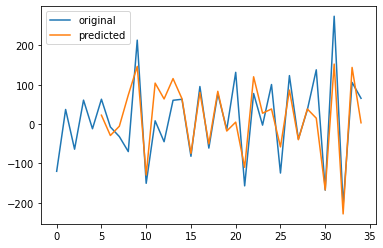

In [7]:
data = pd.read_csv("shampoo.csv", header=0, index_col=0, parse_dates=True, date_parser=parser)
first = data.diff(1).dropna()
ar1 = AR(first, 5)
ar1[["original", "predicted"]].plot()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   29
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -156.530
Date:                Tue, 26 Oct 2021   AIC                            319.060
Time:                        00:24:54   BIC                            323.057
Sample:                             0   HQIC                           320.282
                                 - 29                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4745      0.322     -1.472      0.141      -1.106       0.157
ma.L1         -0.4096      0.275     -1.492      0.136      -0.948       0.129
sigma2      4089.6097   1215.912      3.363      0.0

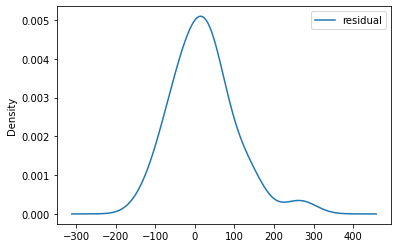

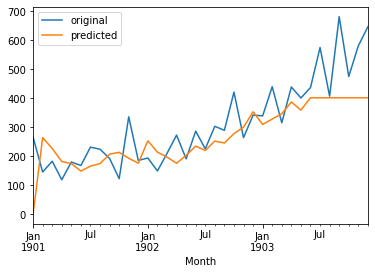

In [160]:
model = ARIMA(data.iloc[:29].values, order=(1,1,1))
# model = ARIMA(first.values, order=(1,1,2))
fitted = model.fit()
print(fitted.summary())
# print(fitted.resid)
pd.DataFrame(fitted.resid, columns=["residual"]).plot(kind="kde")
predicted = fitted.predict(start=0, end=len(first))
# predicted = fitted.predict(start=0, end=len(first)-1)
df = pd.DataFrame()
df["original"] = data.Sales
# df["original"] = first
df["predicted"] = predicted
df[["original", "predicted"]].plot()
# print("Mean squared error:", mean_squared_error(df["original"], df["predicted"]))
print(fitted.forecast(25))


              original   predicted  residuals
Month                                        
1903-01-01  339.700000  296.566796  51.007533
1903-02-01  440.400000  345.471255  98.908489
1903-03-01  315.900000  372.702887 -55.113385
1903-04-01  439.300000  410.739437  37.614166
1903-05-01  352.473702  352.473702   0.000000
1903-06-01  412.300742  412.300742   0.000000
1903-07-01  371.077348  371.077348   0.000000
1903-08-01  399.482033  399.482033   0.000000
1903-09-01  379.909988  379.909988   0.000000
1903-10-01  393.395965  393.395965   0.000000
1903-11-01  384.103549  384.103549   0.000000
1903-12-01  390.506422  390.506422   0.000000


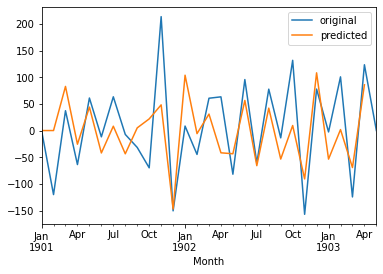

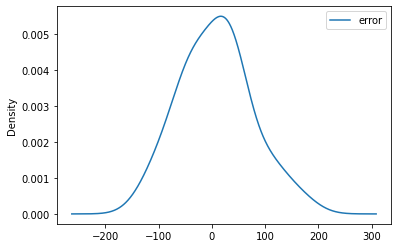

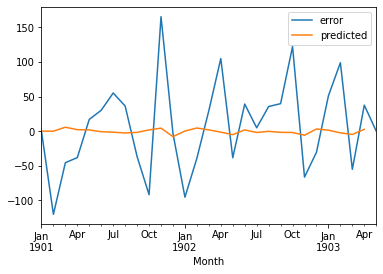

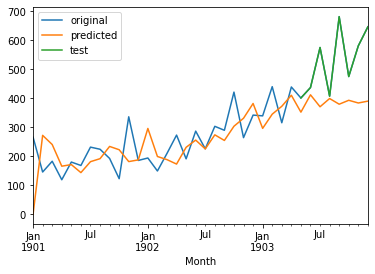

AR coefs: [-0.68904285]
MA coefs: [-0.04781205]
Mean squared error: 0


In [193]:
res, ar_coefs, ma_coefs, rmse, ar, ma = myARIMA(data, 1,1,1)
print("AR coefs:", ar_coefs)
print("MA coefs:", ma_coefs)
print("Mean squared error:", rmse)

In [85]:
ar

,original,lag_1,predicted
Month,,,
1901-01-01,0.0,0.0,0.000000
1901-02-01,-120.1,0.0,0.000000
1901-03-01,37.2,-120.1,82.754046
1901-04-01,-63.8,37.2,-25.632394
1901-05-01,61.0,-63.8,43.960934
1901-06-01,-11.8,61.0,-42.031614
1901-07-01,63.3,-11.8,8.130706
1901-08-01,-7.3,63.3,-43.616412
1901-09-01,-31.7,-7.3,5.030013


In [73]:
from pmdarima.arima import auto_arima
mod = auto_arima(data.iloc[:29].values)
print(mod.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   29
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -154.486
Date:                Mon, 25 Oct 2021   AIC                            316.973
Time:                        23:17:37   BIC                            322.301
Sample:                             0   HQIC                           318.602
                                 - 29                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     11.8673      4.530      2.620      0.009       2.989      20.746
ar.L1         -0.4231      0.365     -1.159      0.246      -1.138       0.292
ma.L1         -0.6706      0.267     -2.514      0.0

/home/mjuan23/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


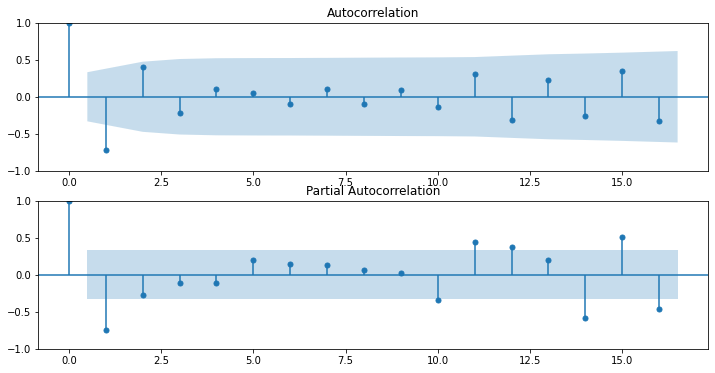

In [12]:
fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(first.dropna(), ax=ax[0], lags=16)
ax[1] = plot_pacf(first.dropna(), ax=ax[1], lags=16)

/home/mjuan23/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


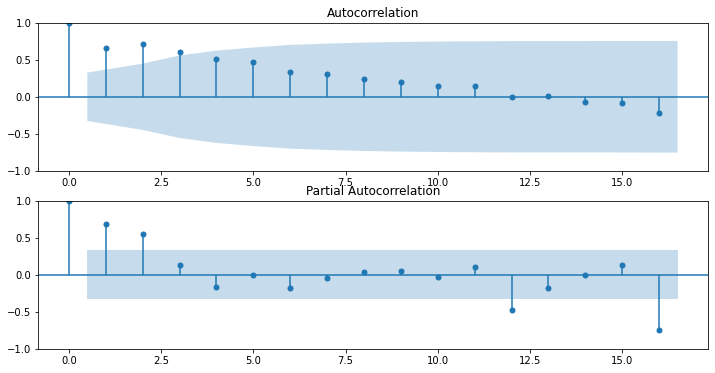

In [13]:
fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(data.dropna(), ax=ax[0], lags=16)
ax[1] = plot_pacf(data.dropna(), ax=ax[1], lags=16)